[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

## Instructions
To run any of Eden's notebooks, please check the guides on our [Wiki page](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki).<br>
There you will find instructions on how to deploy the notebooks on [your local system](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-Locally), on [Google Colab](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-GColab), or on [MyBinder](https://github.com/Eden-Library-AI/eden_library_notebooks/wiki/Deploy-Notebooks-on-MyBinder), as well as other useful links, troubleshooting tips, and more.<br>
For this notebook you will need to download the **Grape vine-210520-Healthy-zz-V1-20210225102831**, datasets from [Eden Library](https://edenlibrary.ai/datasets), and you may want to use the **eden_tensorflow_transfer_learning.yml** file to recreate a suitable conda environment.

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will try to reply as soon as possible.

## Background

In this notebook, we are going to train a autoencoder using Keras and TensorFlow for removing noise from input images.

Autoencoders are a type of unsupervised neural network (i.e., no class labels or labeled data). Typically, autoencoders have two components/subnetworks:

1. **Encoder**: Accepts the input data and compresses it into a latent-space representation ((i.e., a single vector that compresses and quantifies the input).
2. **Decoder**: The decoder is responsible for accepting the latent-space representation and then reconstructing the original input.

Autoencoders are typically used for:

1. **Dimensionality reduction** (similar to PCA).
2. **Denoising**
3. **Anomaly/outlier detection** (e.g.: detecting mislabeled data points in a dataset or detecting when an input data point falls well outside our typical data distribution).

#### Library Imports

In [150]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

#### Auxiliar functions

In [58]:
# Function for plotting images.
def plot_sample(X):
    # Plotting 9 sample images
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(8, 8))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis("off")
            axs[i, j].imshow(X[random.randint(0, X.shape[0]-1)])

def read_data(path_list, im_size=(224,224)):
    
    X = []
    y = []
    
    # Exctract the file-names of the datasets we read and create a label dictionary. 
    tag2idx = {tag.split(os.path.sep)[-1]:i for i, tag in enumerate(path_list)}
    print(tag2idx)
    
    for path in path_list:
        for im_file in tqdm(glob(path + '*/*')): # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2] 
                im = cv2.imread(im_file, cv2.IMREAD_COLOR) 
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                #im = quantize_image(im)
                im = cv2.resize(im, im_size,interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])# Append the label name to y 
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")
    
    X = np.array(X) # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    
    return X, y, tag2idx

#### Experimental Constants

In [81]:
INPUT_SHAPE = (128, 128, 3)
IM_SIZE = (128, 128)
NUM_EPOCHS = 500
BATCH_SIZE = 8
TEST_SPLIT = 0.15
BASE_LEARNING_RATE = 1e-3
RANDOM_STATE = 2021
VERBOSE_LEVEL = 1
AUTO = tf.data.AUTOTUNE
# Datasets' paths we want to work on.
PATH_LIST = ["../eden_library_datasets/Grape vine-210520-Healthy-zz-V1-20210225102831"]

#### Loading Data

In [82]:
X, y, tag2idx = read_data(PATH_LIST, IM_SIZE)

  0%|          | 1/444 [00:00<01:09,  6.37it/s]

{'Grape vine-Vitis vinifera-210520-Healthy-zz': 0}


 66%|██████▋   | 295/444 [00:56<00:23,  6.36it/s]

Not a picture


100%|██████████| 444/444 [01:27<00:00,  5.07it/s]


#### Displaying Original Images

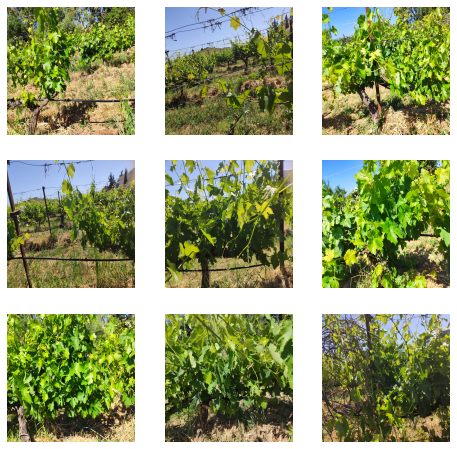

In [83]:
plot_sample(X)

#### Splitting data between train and test

In [84]:
x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SPLIT,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state = RANDOM_STATE)

#### Pre-processing

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#### Adding noise to the original images

In [85]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

#### Displaying Noisy Images

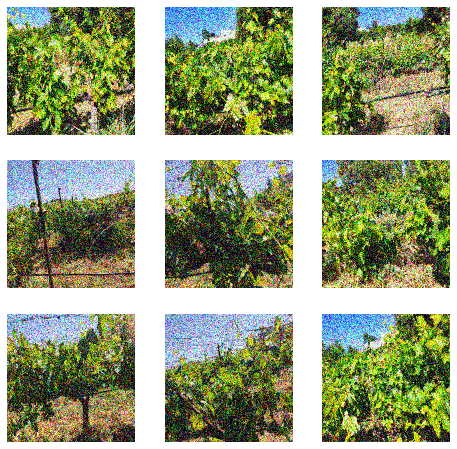

In [86]:
plot_sample(x_train_noisy)

#### Defining Autoencoder

In [162]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(128, 128, 3)),
          layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          #layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),  
        ])

        self.decoder = tf.keras.Sequential([
          #layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [163]:
autoencoder = Denoise()

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
    loss=tf.keras.losses.MeanSquaredError()
)

#### Defining callbaks for improving training efficiency

In [165]:
# If val_loss doesn't improve for a number of epochs set with 'patience' var 
# training will stop to avoid overfitting.   
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                   mode="min",
                                   factor=0.8,
                                   patience = NUM_EPOCHS//20,
                                   verbose=1),
early_stopping = EarlyStopping(monitor="val_loss",
                               mode="min",
                               patience = NUM_EPOCHS//10,
                               verbose=1,
                               restore_best_weights=True),

#### Training the AutoEncoder for removing noise

In [166]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/500
47/47 [==============================] - 1s 12ms/step - loss: 0.0466 - val_loss: 0.0352
Epoch 2/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0284 - val_loss: 0.0229
Epoch 3/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0183 - val_loss: 0.0159
Epoch 4/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 5/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 6/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0131 - val_loss: 0.0122
Epoch 7/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0126 - val_loss: 0.0120
Epoch 8/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 9/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 10/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 11

Epoch 83/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 84/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0074
Epoch 85/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 86/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 87/500
47/47 [==============================] - 0s 10ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 88/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 89/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 90/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 91/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 92/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0072

47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 243/500
47/47 [==============================] - 0s 10ms/step - loss: 0.0064 - val_loss: 0.0067

Epoch 00243: ReduceLROnPlateau reducing learning rate to 0.0008192000910639763.
Epoch 244/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 245/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 246/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 247/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 248/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 249/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 250/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 251/500
47/47 [==

Epoch 320/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 321/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 322/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 323/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 324/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 325/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 326/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 327/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 328/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 329/500
47/47 [==============================] - 0s 9ms/step - loss: 0.0063 - val_los

#### Removing noise with the trained autoencoder

In [167]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

#### Displaying noisy and denoised images

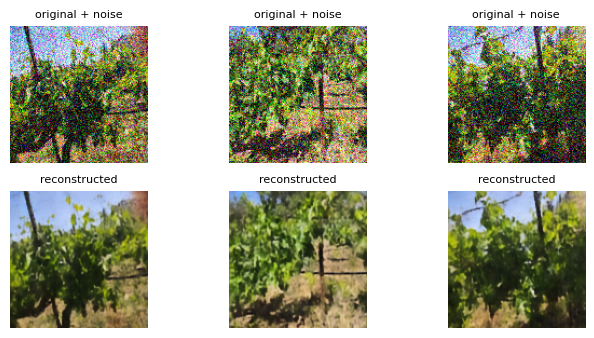

In [168]:
n = 3
plt.figure(figsize=(8, 4), dpi=100)
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise", fontsize=8)
    plt.imshow(x_test_noisy[i])
    ax.axis("off")

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed", fontsize=8)
    plt.imshow(decoded_imgs[i])
    bx.axis("off")
plt.show()

## Possible Extensions
1. Change the number of epochs used while training (500 in this notebook).
2. Use other dataset from the <a href="https://edenlibrary.ai">Eden platform</a>.
3. Change the learning rate used while fine-tuning (1e-3 in this notebook).